In [176]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import layers, losses
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')


In [236]:
test_name = 'anomaly5_FL_5epochs'#'descentralized_all_w_local_training_wo_global_data'
loss = 'mse'
model = 'All'
model_type = 'CNN'

anom_clients = [0,1,2,3,4]

datas = []
for i in ['train', 'evaluate_before_train', 'evaluate']:

    file = f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/synthetic/{model_type}/{test_name}/{i}/loss_{loss}_{model}.csv'
    names = ['cid', 'round', 'loss','diff', 'anomaly', 'anomaly2', 'anomaly3']

    data = pd.read_csv(file,
                    names = names)
    
    data['client_anom'] = data['cid'].apply(lambda x: 1 if x in anom_clients else 0)
    
    datas.append(data)

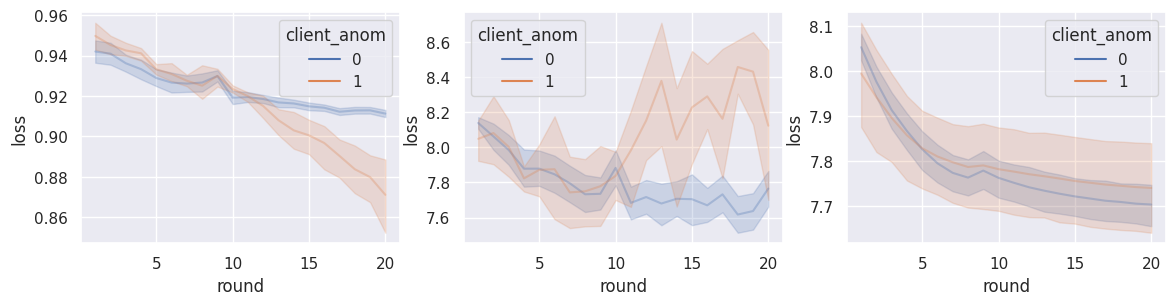

In [237]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    sns.lineplot(datas[i], x = 'round', y = 'loss', ax = axs[i], hue='client_anom', alpha = 0.3)

<AxesSubplot:xlabel='round', ylabel='loss'>

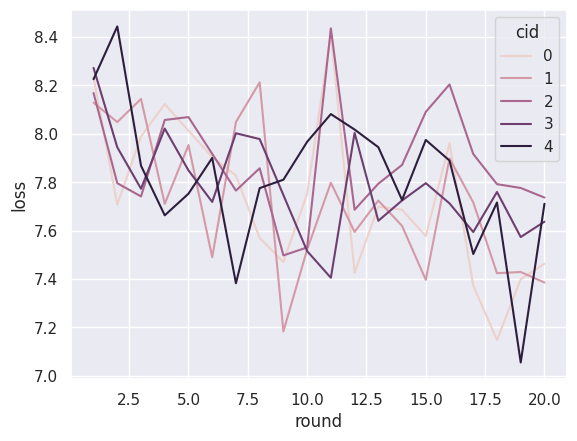

In [186]:
sns.lineplot(datas[1][datas[1]['cid'].isin( [0,1,2,3,4])], x = 'round', y = 'loss', hue = 'cid')

In [180]:
for i in range(3):

    df = datas[i].copy()
    df['anomaly'] = 0
    df['anomaly2'] = 0
    df['anomaly3'] = 0
    df['anomaly12'] = 0

    cids = [0,1,2,3,4]

    #df['true_anomaly'] = df['round'].apply(lambda x: 1 if x>=10 else 0)
    #idx = df[df['cid'].isin(cids)].index.values[0] 
    #df.at[idx, 'true_anomaly']= 1
    df['true_anomaly'] = 0
    df.loc[(df['cid'].isin(cids)*df['round'].isin([11])), ['true_anomaly']] = 1

    th = 1.5

    for cid in range(15):
        for r in range(1, 20):

            if r>3:
                try:
                    diff = df[(df['cid'] == cid) & (df['round'] == r)]['loss'].values[0]

                    diff1 = df[(df['cid'] == cid) & (df['round'] == r-1)]['loss'].values[0]
                    diff2 = df[(df['cid'] == cid) & (df['round'] == r-2)]['loss'].values[0]
                    diff3 = df[(df['cid'] == cid) & (df['round'] == r-3)]['loss'].values[0]
                    mean_diff = np.mean([diff1, diff2, diff3])

                    anomaly = 0
                    if diff >= th*mean_diff: #se cresceu mais que o esperado, é a nomalia
                        anomaly = 1

                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly']= anomaly


                    diff = abs(df[(df['cid'] == cid) & (df['round'] == r)]['diff'].values[0])

                    diff1 = abs(df[(df['cid'] == cid) & (df['round'] == r-1)]['diff'].values[0])
                    diff2 = abs(df[(df['cid'] == cid) & (df['round'] == r-2)]['diff'].values[0])
                    diff3 = abs(df[(df['cid'] == cid) & (df['round'] == r-3)]['diff'].values[0])
                    mean_diff = np.mean([diff1, diff2, diff3])

                    anomaly3 = 0
                    if diff <= th*mean_diff: #se cresceu mais que o esperado, é a nomalia
                        anomaly3 = 1

                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly3']= anomaly3

                    anomaly2 = 0
                    loss =  df[(df['cid'] == cid) & (df['round'] == r)]['loss'].values[0]
                    last_losses1 = df[(df['cid'] == cid) & (df['round'] == r-1)]['loss'].values[0]
                    last_losses2 = df[(df['cid'] == cid) & (df['round'] == r-2)]['loss'].values[0]

                    if (loss - last_losses1) > 0:
                        if (last_losses1 - last_losses2) > 0:
                            anomaly2 = 1 
                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly2']= anomaly2

                except IndexError:
                    anomaly = df[df['cid'] == cid]['anomaly'].tail(1).values[0]

    df['anomaly12'] = df['anomaly'] + df['anomaly2'] 
    df['anomaly12'] = df['anomaly12'].apply(lambda x: 1 if x==2 else x)

    df['anomaly32'] = df['anomaly2'] + df['anomaly3'] 
    df['anomaly32'] = df['anomaly32'].apply(lambda x: 1 if x==2 else x)

    data = df.copy()
    print('Anomaly',f1_score(data['true_anomaly'], data['anomaly']),
        precision_score(       data['true_anomaly'], data['anomaly']),
        recall_score(          data['true_anomaly'], data['anomaly']),
        accuracy_score(        data['true_anomaly'], data['anomaly']))

    print('Anomaly2',f1_score(data['true_anomaly'], data['anomaly2']),
        precision_score(       data['true_anomaly'], data['anomaly2']),
        recall_score(          data['true_anomaly'], data['anomaly2']),
        accuracy_score(        data['true_anomaly'], data['anomaly2']))

    print('Anomaly3',f1_score(data['true_anomaly'],  data['anomaly3']),
        precision_score(       data['true_anomaly'], data['anomaly3']),
        recall_score(          data['true_anomaly'], data['anomaly3']),
        accuracy_score(        data['true_anomaly'], data['anomaly3']))
    
    print('Anomaly32',f1_score(data['true_anomaly'], data['anomaly32']),
        precision_score(       data['true_anomaly'], data['anomaly32']),
        recall_score(          data['true_anomaly'], data['anomaly32']),
        accuracy_score(        data['true_anomaly'], data['anomaly32']))
    
    
    print('-----------')


Anomaly 0.0 0.0 0.0 0.9914821124361158
Anomaly2 0.0 0.0 0.0 0.9574105621805792
Anomaly3 0.013422818791946308 0.006944444444444444 0.2 0.7495741056218058
Anomaly32 0.013157894736842105 0.006802721088435374 0.2 0.7444633730834753
-----------
Anomaly 0.0 0.0 0.0 0.9915397631133672
Anomaly2 0.2285714285714286 0.13333333333333333 0.8 0.9543147208121827
Anomaly3 0.0392156862745098 0.02027027027027027 0.6 0.751269035532995
Anomaly32 0.04938271604938272 0.025477707006369428 0.8 0.739424703891709
-----------
Anomaly 0.0 0.0 0.0 0.9916387959866221
Anomaly2 0.0 0.0 0.0 0.9765886287625418
Anomaly3 0.053691275167785234 0.027777777777777776 0.8 0.7642140468227425
Anomaly32 0.05333333333333333 0.027586206896551724 0.8 0.7625418060200669
-----------


In [181]:
data['anomaly'].value_counts()

0    598
Name: anomaly, dtype: int64

In [182]:
data[data['round'] == 11]

,cid,round,loss,diff,anomaly,anomaly2,anomaly3,client_anom,anomaly12,true_anomaly,anomaly32
298,24,11,7.703806,0.037436,0,0,0,0,0,0,0
299,3,11,7.553671,0.187571,0,0,1,1,0,1,1
300,11,11,7.775357,0.071551,0,0,1,0,0,0,1
301,2,11,7.888711,0.184905,0,0,1,1,0,1,1
302,9,11,7.771368,0.117343,0,0,1,0,0,0,1
303,12,11,7.714875,0.056493,0,0,1,0,0,0,1
304,23,11,7.938840,0.167472,0,0,0,0,0,0,0
305,25,11,7.615564,0.323276,0,0,0,0,0,0,0
306,22,11,7.866671,0.251106,0,0,0,0,0,0,0
307,29,11,7.531381,0.335290,0,0,0,0,0,0,0


In [183]:
#testar sem parar o treinamento dos clientes anomalos
#testar usando outras anomalias
#testar sem anomalias